# TFM - Predicción potenciales compradores de un ecommerce

Evolución del notebook *Modelo_1.ipynb* unicamente aplicando a **personas físicas**

------------------------------------

------------------

### 1.1 Librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

from collections import Counter

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

------------------

### 1.2 Variables globales

In [3]:
LABELS = ["No_Cliente","Cliente"]

------------------

### 1.3 Funciones

In [4]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

------------------------------------

------------------

A continuación comenzamos leyendo los ficheros que hemos tratado, limpiado y analizado en los procesos anteriores.

Se realizará un análisis sencillo de la estructura y una visualización de varias muestras. 

Además someteremos las variables categóricas a variables *dummies*, de forma que que podamos introducirlas ennuestro modelo.

### 2.1 Lectura de Fichero

In [5]:
df = pd.read_csv('Data/dataset_model_corr.txt', sep = ';', encoding = 'ISO-8859-1')

In [6]:
df.shape

(406267, 26)

In [7]:
df.head(3)

,TIPOUSUARIO,FECHA_REGISTRO_WEEKDAY,FECHA_REGISTRO_MONTH,CANAL_REGISTRO,TIPOEMAIL,BONDAD_EMAIL,TIPO_TELF,IP_CONTINENTE,IP_COUNTRY_PIB,USU_TIPO,USU_TAMANIO,USU_ESTADO,USU_SECTOR_ECONOMICO,1A_DESCGRUPOPROD,1A_EMPCONSUL_EST,1A_EMPCONSUL_SECTOR,IPCASOS,IP_COUNTRY_IDH_NUM,USU_DEPART_DEN_POB,USU_DEPART_IDH,1A_EMPCONSUL_PROV_DENS,1A_EMPCONSUL_PROV_IDH,FICH_PROMO_TOT,PERF_PROMO_TOT,IND_ALTA,IND_CLIENTE
0,PF,1,10,3,GOOHOTYAHMAIL,0,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,NoApl,NoApl,NoApl,NoApl,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,-1.00,-1.000,47.92,0.782,0,1,0,0
1,PJ,1,5,3,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,PQ,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,SD,1,0.767,306.38,0.832,47.92,0.782,0,1,0,0
2,PJ,2,9,7,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,MC,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,815.17,0.835,4438.75,0.904,0,1,0,0


------------------

### 2.2 Variables dummies

In [8]:
ohe_columns = ['TIPOUSUARIO','FECHA_REGISTRO_WEEKDAY','FECHA_REGISTRO_MONTH','CANAL_REGISTRO','TIPOEMAIL','TIPO_TELF','IP_CONTINENTE','IP_COUNTRY_PIB','USU_TIPO',
               'USU_TAMANIO','USU_ESTADO','USU_SECTOR_ECONOMICO','1A_DESCGRUPOPROD','1A_EMPCONSUL_EST','1A_EMPCONSUL_SECTOR']

In [9]:
final_df = pd.get_dummies(df, columns = ohe_columns)

**Columnas para la predicción**

In [10]:
columnas = ['TIPOUSUARIO_PF','FECHA_REGISTRO_WEEKDAY_0','FECHA_REGISTRO_WEEKDAY_1', 'FECHA_REGISTRO_WEEKDAY_2','FECHA_REGISTRO_WEEKDAY_3', 
            'FECHA_REGISTRO_WEEKDAY_4','FECHA_REGISTRO_WEEKDAY_5', 'FECHA_REGISTRO_WEEKDAY_6','FECHA_REGISTRO_MONTH_1', 'FECHA_REGISTRO_MONTH_2',
            'FECHA_REGISTRO_MONTH_3', 'FECHA_REGISTRO_MONTH_4','FECHA_REGISTRO_MONTH_5', 'FECHA_REGISTRO_MONTH_6','FECHA_REGISTRO_MONTH_7', 'FECHA_REGISTRO_MONTH_8',
            'FECHA_REGISTRO_MONTH_9', 'FECHA_REGISTRO_MONTH_10','FECHA_REGISTRO_MONTH_11', 'FECHA_REGISTRO_MONTH_12','CANAL_REGISTRO_1', 'CANAL_REGISTRO_2', 'CANAL_REGISTRO_3',
            'CANAL_REGISTRO_4', 'CANAL_REGISTRO_5', 'CANAL_REGISTRO_6', 'CANAL_REGISTRO_7', 'CANAL_REGISTRO_8', 'CANAL_REGISTRO_9','TIPOEMAIL_ADMINISTRACION','TIPOEMAIL_CORPORATIVO',
            'TIPOEMAIL_DOCENTE','TIPOEMAIL_GOOHOTYAHMAIL','TIPOEMAIL_SINCLASIFICAR','TIPOEMAIL_TEMPORAL','BONDAD_EMAIL','IPCASOS','TIPO_TELF_EXTRANJERO',
            'TIPO_TELF_MOVIL', 'TIPO_TELF_NO_PUBLICO','IP_CONTINENTE_AFRICA','IP_CONTINENTE_AMERICA_NORTE','IP_CONTINENTE_AMERICA_SUR','IP_CONTINENTE_ASIA','IP_CONTINENTE_EUROPA',
            'IP_CONTINENTE_NI','IP_CONTINENTE_OCEANNIA', 'IP_COUNTRY_PIB_Ingreso alto','IP_COUNTRY_PIB_Ingreso mediano alto','IP_COUNTRY_PIB_NI',
            'IP_COUNTRY_PIB_Países de ingreso mediano bajo','IP_COUNTRY_IDH_NUM','FICH_PROMO_TOT','PERF_PROMO_TOT','1A_EMPCONSUL_EST_ACTIVA', 
            '1A_EMPCONSUL_EST_INACTIVA', '1A_DESCGRUPOPROD_FICH_PROMO', '1A_DESCGRUPOPROD_PERF_PROMO', '1A_DESCGRUPOPROD_RES_PAGO', '1A_EMPCONSUL_EST_NI', 
            '1A_EMPCONSUL_EST_REESTRUCTURACION', '1A_EMPCONSUL_EST_RELACION_CLINTON', '1A_EMPCONSUL_SECTOR_CUATERNARIO', '1A_EMPCONSUL_SECTOR_PRIMARIO', '1A_EMPCONSUL_SECTOR_QUINARIO',
            '1A_EMPCONSUL_SECTOR_SD', '1A_EMPCONSUL_SECTOR_SECUNDARIO', '1A_EMPCONSUL_SECTOR_TERCIARIO']

-----------------

------------------

### 3.1 Analisis desbalanceo

In [11]:
final_df.shape

(406267, 100)

In [12]:
pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PF'] == 1, 'IND_CLIENTE'], sort = True)

0    296938
1      3831
Name: IND_CLIENTE, dtype: int64

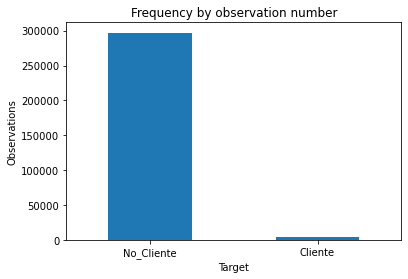

In [13]:
count_classes = pd.value_counts(final_df.loc[final_df['TIPOUSUARIO_PF'] == 1, 'IND_CLIENTE'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Target")
plt.ylabel("Observations");

In [14]:
print('Los clientes suponen un % del total: ', ((3831/(len(final_df.loc[final_df['TIPOUSUARIO_PF'] == 1])))*100))

Los clientes suponen un % del total:  1.2737349926355441


**Podemos ver un claro desbalanceo donde los clientes no suponen más del 2% de las observaciones**

------------------

------------------

### 4. Creación del Modelo

#### 4.1 Dividimos el set entre features y label

In [19]:
final_df_PF = final_df.loc[final_df['TIPOUSUARIO_PF'] == 1]

In [20]:
features = final_df_PF[columnas]
labels = final_df_PF['IND_CLIENTE']

In [21]:
features.shape

(300769, 68)

In [22]:
labels.shape

(300769,)

------------------

#### 4.2 Creamos set de entrenamiento y test

In [23]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [24]:
train_x.shape

(210538, 68)

In [25]:
test_x.shape

(90231, 68)

In [26]:
train_y.shape

(210538,)

In [27]:
test_y.shape

(90231,)

------------------

#### 4.3 Selección Hiperparámetros

Definimos una serie de hiperparámetros diferentes para comparar resultados

In [28]:
param_grid = ParameterGrid({'n_estimators': [5, 20, 50, 100, 150],
                            'max_features': [5, 'log2', 'auto', 'sqrt'],
                            'max_depth'   : [None, 3, 5, 7, 10],
                            'criterion'   : ['gini', 'entropy']
                           })

Loop para ajustar un modelo con cada combinación de hiperparámetros

In [29]:
resultados = {'params': [], 'oob_accuracy': []}

In [30]:
for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 20} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 20} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 

In [31]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(10)

,oob_accuracy,criterion,max_depth,max_features,n_estimators
109,0.996803,entropy,NaN,log2,150
4,0.996799,gini,NaN,5,150
9,0.996794,gini,NaN,log2,150
119,0.996770,entropy,NaN,sqrt,150
114,0.996770,entropy,NaN,auto,150
19,0.996770,gini,NaN,sqrt,150
14,0.996770,gini,NaN,auto,150
104,0.996761,entropy,NaN,5,150
8,0.996704,gini,NaN,log2,100
3,0.996699,gini,NaN,5,100


**Seleccionamos los mejores hiperparámetros**

In [32]:
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print('--------------------------------------------------')
print("Estimators: \n", resultados.iloc[0,:], "accuracy")

Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
Estimators: 
 oob_accuracy    0.996803
criterion        entropy
max_depth            NaN
max_features        log2
n_estimators         150
Name: 109, dtype: object accuracy


--------------

--------------

#### 4.4 Modelo 1 - Baseline

Nuestro modelo Base, tendrá los parámetros obtenidos como mejores anteriormente.

**Aplicamos los mejores hiperparámetros obtenidos**

In [40]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'log2', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150, n_jobs=-1, random_state=123)

Observamos los resultados del modelo

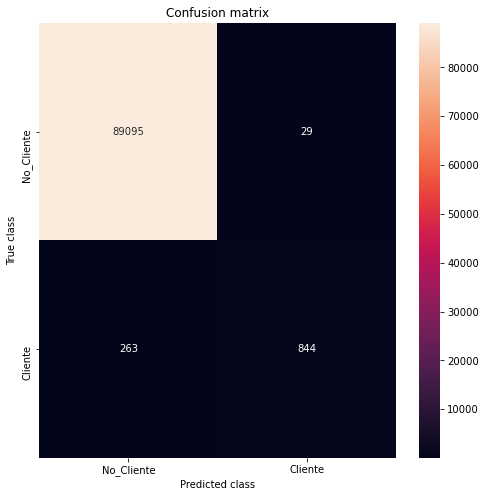

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89124
           1       0.97      0.76      0.85      1107

    accuracy                           1.00     90231
   macro avg       0.98      0.88      0.93     90231
weighted avg       1.00      1.00      1.00     90231



In [41]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [42]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [43]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,24.790143
IPCASOS,10.728892
PERF_PROMO_TOT,4.246839
BONDAD_EMAIL,3.101618
TIPO_TELF_MOVIL,1.995691
1A_EMPCONSUL_SECTOR_TERCIARIO,1.899664
IP_COUNTRY_IDH_NUM,1.891470
TIPO_TELF_EXTRANJERO,1.846852
1A_EMPCONSUL_SECTOR_SECUNDARIO,1.670923
FECHA_REGISTRO_WEEKDAY_1,1.611921


In [44]:
feature_importances[feature_importances['important'] > 0.01].shape

(34, 1)

------

------

------

#### 4.5 Modelo - Aplicando técnicas sobre el desbalanceo

**Estrategias para el manejo de Datos Desbalanceados**

##### **4.5.1 Penalización para compensar**

In [45]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'log2', 
                            max_depth = None,
                            n_jobs = -1,
                            random_state = 123,
                            class_weight = 'balanced')

rf.fit(train_x, train_y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=150, n_jobs=-1,
                       random_state=123)

Observamos los resultados del modelo

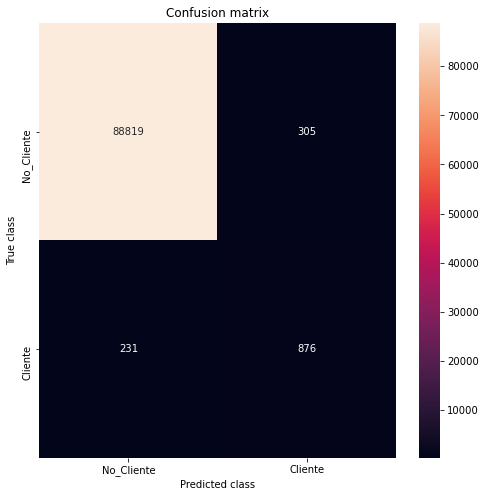

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89124
           1       0.74      0.79      0.77      1107

    accuracy                           0.99     90231
   macro avg       0.87      0.89      0.88     90231
weighted avg       0.99      0.99      0.99     90231



In [46]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [47]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [48]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,27.585081
IPCASOS,9.861517
BONDAD_EMAIL,5.322302
PERF_PROMO_TOT,3.861089
TIPO_TELF_MOVIL,1.881657
IP_COUNTRY_PIB_Ingreso mediano alto,1.724448
TIPO_TELF_EXTRANJERO,1.708629
1A_EMPCONSUL_SECTOR_TERCIARIO,1.663822
IP_COUNTRY_IDH_NUM,1.575189
FECHA_REGISTRO_WEEKDAY_0,1.467183


In [49]:
feature_importances[feature_importances['important'] > 0.01].shape

(29, 1)

------

##### **4.5.2 Subsampling en la clase mayoritaria**

**RandomUnderSampler**

In [50]:
us = RandomUnderSampler(sampling_strategy = 'majority', random_state = 123)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 207814, 1: 2724})
Distribution after resampling Counter({0: 2724, 1: 2724})


In [51]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'log2', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150, n_jobs=-1, random_state=123)

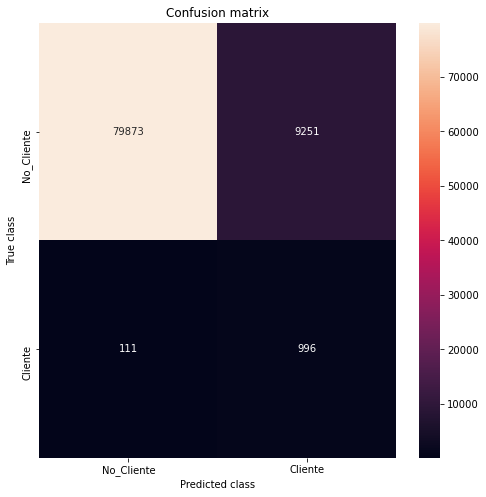

              precision    recall  f1-score   support

           0       1.00      0.90      0.94     89124
           1       0.10      0.90      0.18      1107

    accuracy                           0.90     90231
   macro avg       0.55      0.90      0.56     90231
weighted avg       0.99      0.90      0.94     90231



In [52]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [53]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [54]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,26.348087
IPCASOS,8.894694
BONDAD_EMAIL,5.078015
PERF_PROMO_TOT,3.780523
IP_COUNTRY_IDH_NUM,1.896772
TIPO_TELF_EXTRANJERO,1.872811
TIPO_TELF_MOVIL,1.766205
1A_EMPCONSUL_SECTOR_TERCIARIO,1.735374
CANAL_REGISTRO_3,1.578504
IP_COUNTRY_PIB_Ingreso mediano alto,1.575307


In [55]:
feature_importances[feature_importances['important'] > 0.01].shape

(30, 1)

------

##### **4.5.3 Oversampling en la clase minoritaria**

**SMOTE**

In [57]:
os =  SMOTE(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 207814, 1: 2724})
Distribution labels after resampling Counter({0: 207814, 1: 207814})


In [58]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'log2', 
                            max_depth = None,
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150, n_jobs=-1, random_state=123)

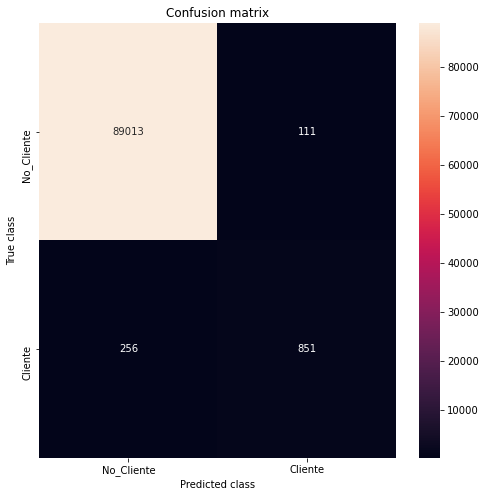

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89124
           1       0.88      0.77      0.82      1107

    accuracy                           1.00     90231
   macro avg       0.94      0.88      0.91     90231
weighted avg       1.00      1.00      1.00     90231



In [59]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [60]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [61]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,24.606411
IPCASOS,8.966832
BONDAD_EMAIL,4.417934
PERF_PROMO_TOT,3.052056
CANAL_REGISTRO_3,2.672137
TIPO_TELF_MOVIL,2.260756
CANAL_REGISTRO_2,2.095913
TIPO_TELF_EXTRANJERO,1.973354
CANAL_REGISTRO_8,1.906853
IP_COUNTRY_IDH_NUM,1.903069


In [62]:
feature_importances[feature_importances['important'] > 0.01].shape

(36, 1)

------

##### **4.5.4 Combinamos OverSampling con Subsampling**

**Combinando SMOTE & RandomUnderSampler**

In [63]:
over = SMOTE(sampling_strategy = 0.3)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [64]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [65]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 207814, 1: 2724})
Distribution after resampling Counter({0: 124688, 1: 62344})


In [66]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'log2', 
                            max_depth = None,
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150, n_jobs=-1, random_state=123)

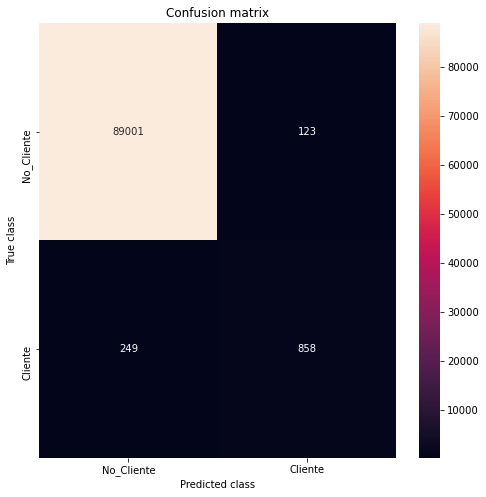

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89124
           1       0.87      0.78      0.82      1107

    accuracy                           1.00     90231
   macro avg       0.94      0.89      0.91     90231
weighted avg       1.00      1.00      1.00     90231



In [67]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [68]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [69]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
FICH_PROMO_TOT,25.249000
IPCASOS,8.869345
BONDAD_EMAIL,4.289182
PERF_PROMO_TOT,3.265604
CANAL_REGISTRO_3,2.628905
TIPO_TELF_MOVIL,2.183751
IP_COUNTRY_IDH_NUM,2.171188
TIPO_TELF_EXTRANJERO,2.039261
CANAL_REGISTRO_2,1.895347
1A_EMPCONSUL_SECTOR_TERCIARIO,1.832337


In [70]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

**SMOTETomek**

In [71]:
os_us = SMOTETomek(sampling_strategy = 'all')
X_train_res, y_train_res = os_us.fit_resample(train_x, train_y)

In [72]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 207814, 1: 2724})
Distribution after resampling Counter({0: 207812, 1: 207812})


In [73]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 150, 
                            max_features = 'log2', 
                            max_depth = None,  
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150, n_jobs=-1, random_state=123)

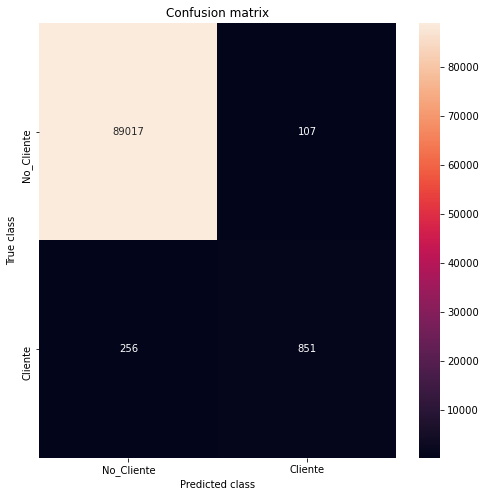

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89124
           1       0.89      0.77      0.82      1107

    accuracy                           1.00     90231
   macro avg       0.94      0.88      0.91     90231
weighted avg       1.00      1.00      1.00     90231



In [74]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [75]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [76]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
FICH_PROMO_TOT,25.218554
IPCASOS,8.812362
BONDAD_EMAIL,4.260596
PERF_PROMO_TOT,3.093040
CANAL_REGISTRO_3,2.687196
CANAL_REGISTRO_2,2.096063
TIPO_TELF_MOVIL,2.083883
IP_COUNTRY_IDH_NUM,2.027703
TIPO_TELF_EXTRANJERO,1.992187
1A_EMPCONSUL_SECTOR_TERCIARIO,1.810146


In [77]:
feature_importances[feature_importances['important'] > 0.01].shape

(35, 1)

------

------

##### **4.5.5 Ensamble de Modelos con Balanceo**

Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging y el modelo será un RandomForest.

**Bagging**

In [78]:
bbc = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion = 'entropy', 
                                                                        n_estimators = 150, 
                                                                        max_features = 'log2', 
                                                                        max_depth = None,
                                                                        n_jobs = -1,
                                                                        random_state = 123),
                                sampling_strategy = 'all',
                                n_estimators = 40,
                                replacement = False,
                                random_state = 123)

bbc.fit(train_x, train_y)

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                                max_features='log2',
                                                                n_estimators=150,
                                                                n_jobs=-1,
                                                                random_state=123),
                          n_estimators=40, random_state=123,
                          sampling_strategy='all')

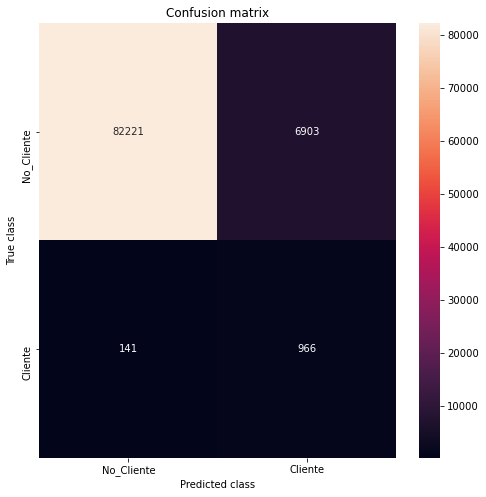

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     89124
           1       0.12      0.87      0.22      1107

    accuracy                           0.92     90231
   macro avg       0.56      0.90      0.59     90231
weighted avg       0.99      0.92      0.95     90231



In [79]:
pred_y = bbc.predict(test_x)
mostrar_resultados(test_y, pred_y)

------

**RUSBoostClassifier**

In [80]:
RUS = RUSBoostClassifier(base_estimator = RandomForestClassifier(criterion = 'entropy', 
                                                                n_estimators = 150, 
                                                                max_features = 'log2', 
                                                                max_depth = None,
                                                                 n_jobs = -1,
                                                                 random_state = 123),
                                sampling_strategy = 'majority',
                                n_estimators = 20,
                                replacement = False,
                                random_state = 123)

RUS.fit(train_x, train_y)

RUSBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         max_features='log2',
                                                         n_estimators=150,
                                                         n_jobs=-1,
                                                         random_state=123),
                   n_estimators=20, random_state=123,
                   sampling_strategy='majority')

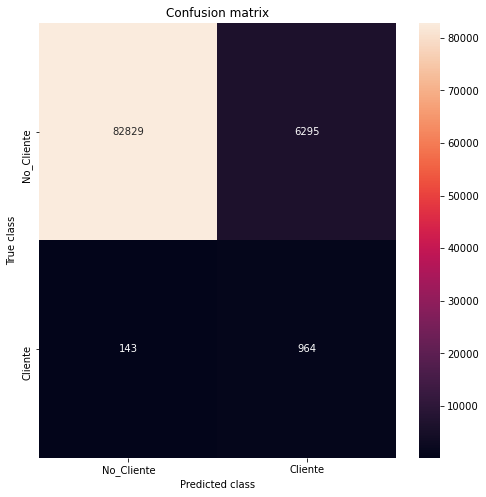

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     89124
           1       0.13      0.87      0.23      1107

    accuracy                           0.93     90231
   macro avg       0.57      0.90      0.60     90231
weighted avg       0.99      0.93      0.95     90231



In [81]:
pred_y = RUS.predict(test_x)
mostrar_resultados(test_y, pred_y)

---------------

---------------

---------------

# CONCLUSIONES

| Modelo | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | NoClientes F1-score | Clientes - Precision | Clientes - Recall | Clientes F1-score | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Baseline | 1.00 | 1.00 | 1.00 | **1.00** | 0.97 | 0.76 | **0.85** | 34 |  

### **Resultados** 

| Modelo |Tecnica |Algoritmo   | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | NoClientes F1-score | Clientes - Precision | Clientes - Recall | Clientes F1-score | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Modelo 1 | **Penalización para compensar** | -- | 0.99 | 1.00 | 1.00 | **1.00** | 0.74 | 0.79 | **0.77** | 29 |
| Modelo 2 | **Subsampling en la clase mayoritaria** | RandomUnderSampler | 0.9 | 1.00 | 0.9 | **0.94** | 0.1 | 0.9 | **0.18** | 30 |
| Modelo 3 | **Oversampling en la clase minoritaria** | SMOTE| 1.00 | 1.00 | 1.00 | **1.00** | 0.88 | 0.77 | **0.82** | 36 |
| Modelo 4 | **Combinamos OverSampling con Subsampling** | SMOTE & RandomUnderSampler | 1.00 | 1.00 | 1.00 | **1.00** | 0.87 | 0.78 | **0.82** | 32 |
| Modelo 5 | **Combinamos OverSampling con Subsampling** | SMOTE-Tomek| 1.00 | 1.00 | 1.00 | **1.00** | 0.89 | 0.77 | **0.82** | 35 |
| Modelo 6 | **Ensamble de Modelos con Balanceo** | BalancedBaggingClassifier| 0.92 | 1.00 | 0.92 | **0.96** | 0.12 | 0.87 | **0.22**  | -- |
| Modelo 7 | **Ensamble de Modelos con Balanceo** | RUSBoostClassifier| 0.93 | 1.00 | 0.93 | **0.96** | 0.13 | 0.87 | **0.23** | -- |

Tras los resultados obtenidos y expuestos, podemos concluir que las técnicas que mejores resultados nos han proporcionado estan entre **Oversampling en la clase minoritaria** y **Combinación OverSampling con Subsampling**. Los resultados de las técnicas son muy parecidos al del modelo Base.

Análizando las diferentes métricas obtenidas, en primer lugar nos fijamos que todos las diferentes técnicas tienen un F1-score de la clase No Clientes muy similar entre ellas, por lo que marcará la diferencias será la clase Clientes.

Observando que el modelo base y las técnicas SMOTE y las de combinación de oversampling y subsampling son los que mejor F1 en la clase clientes tienen, analizaremos en detalle la precisión y recall de cada uno.Unicamente la técnica de ensamblado de modelos con balanceo son los que peor resultado han proporcionado, en los que a F1 de la clase Clientes se refiere.

Sin embargo, entendiendo que el objetivo del negocio es poder desarrollar una estrategia en base a un determinado grupo, lo que premiaremos es el modelo que mejor recall tenga, ya que lo que interesa es detectar bien la clase clientes.

**En este caso preferiremos enviar ofertas a más clientes que perder clientes que si lo son**

El modelo que mejor responde a esto es el que utiliza la técnica **Ensamble de Modelos con Balanceo**, en concreto un boosting, que parece que tiene mejor recall de la clase No Clientes.